In [1]:
import sys
sys.path.append('/home/g201381710/ExperimentsGH/DotlessArabic2/DotlessArabic')
sys.path.append('/home/g201381710/.local/lib/python3.10/site-packages')
sys.path.append('/home/g201381710/anaconda3/envs/dl4/lib/python3.10/site-packages')

sys.path

['/home/g201381710/ExperimentsGH/DotlessArabic2/DotlessArabic/dotless_arabic/analysis/notebooks',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/g201381710/.local/lib/python3.10/site-packages',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages/IPython/extensions',
 '/home/g201381710/.ipython',
 '/home/g201381710/ExperimentsGH/DotlessArabic2/DotlessArabic',
 '/home/g201381710/.local/lib/python3.10/site-packages',
 '/home/g201381710/anaconda3/envs/dl4/lib/python3.10/site-packages']

In [2]:
import re,random,math
from collections import Counter
from functools import lru_cache

from farasa.segmenter import FarasaSegmenter

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import linregress

from dotless_arabic.processing import process,undot

from dotless_arabic.tokenizers import DisjointLetterTokenizer,FarasaMorphologicalTokenizer, WordTokenizer

from dotless_arabic.datasets.news.collect import collect_dataset_for_analysis as collect_news_dataset_for_analysis
from dotless_arabic.datasets.quran.collect import collect_dataset_for_analysis as collect_quran_dataset_for_analysis
from dotless_arabic.datasets.poems.collect import collect_dataset_for_analysis as collect_poems_dataset_for_analysis
from dotless_arabic.datasets.wikipedia.collect import collect_dataset_for_analysis as collect_wikipedia_dataset_for_analysis
from dotless_arabic.datasets.aggregated.collect import collect_dataset_for_analysis as collect_aggregated_dataset_for_analysis
from dotless_arabic.datasets.sanadset_hadeeth.collect import collect_dataset_for_analysis as collect_sanadset_hadeeth_dataset_for_analysis

In [3]:
random.seed(42)

# functions

In [4]:
tokenizer = DisjointLetterTokenizer()

In [5]:
@lru_cache()
def tokenize_dataset(dataset):
    tokenized_dataset = list()
    if isinstance(tokenizer,FarasaMorphologicalTokenizer):
        segmenter = FarasaSegmenter(interactive=True)
    for document in tqdm(dataset):
        if isinstance(tokenizer,FarasaMorphologicalTokenizer):
            tokenized_document = " ".join(
                tokenizer.split_text(
                    document,
                    segmenter=segmenter,
                )
            )
        else:
            tokenized_document = " ".join(tokenizer.split_text(document))
        tokenized_document = tokenized_document.replace("<##>", "")
        tokenized_document = re.sub("\s+", " ", tokenized_document)
        tokenized_dataset.append(tokenized_document)
    return tokenized_dataset

In [6]:
@lru_cache()
def words_counter(dataset,use_tqdm=True):
    if not use_tqdm:
        return Counter(word for item in dataset for word in item.split())    
    return Counter(word for item in tqdm(dataset) for word in item.split())

@lru_cache()
def undot_dataset(dataset):
    return list(map(undot, tqdm(dataset)))

@lru_cache()
def process_dataset(dataset):
    return list(map(process, tqdm(dataset)))

In [7]:
# tokenize datasets
all_datasets = [
    tokenize_dataset(dataset=tuple(collect_quran_dataset_for_analysis())),
    tokenize_dataset(dataset=tuple(collect_sanadset_hadeeth_dataset_for_analysis())),
    tokenize_dataset(dataset=tuple(collect_poems_dataset_for_analysis())),
    tokenize_dataset(dataset=tuple(collect_wikipedia_dataset_for_analysis())),
    tokenize_dataset(dataset=tuple(collect_news_dataset_for_analysis())),
#     tokenize_dataset(dataset=tuple(collect_raw_aggregated_dataset())),
]

aggregated_dataset = []
for _dataset in all_datasets:
    aggregated_dataset.extend(_dataset)
all_datasets.append(aggregated_dataset)

  0%|          | 0/6236 [00:00<?, ?it/s]

####################################################################################################
Original Number of Samples:
650,986
####################################################################################################
####################################################################################################
Number of Samples after dropping duplicates:
637,565
####################################################################################################


  0%|          | 0/637565 [00:00<?, ?it/s]

Using custom data configuration MagedSaeed--ashaar-719bb58a76ea0092
Found cached dataset parquet (/home/g201381710/.cache/huggingface/datasets/arbml___parquet/MagedSaeed--ashaar-719bb58a76ea0092/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/7714858 [00:00<?, ?it/s]

  0%|          | 0/4636663 [00:00<?, ?it/s]

  0%|          | 0/2784041 [00:00<?, ?it/s]

In [8]:
# process datasets
all_datasets = [
    process_dataset(dataset=tuple(all_datasets[0])),
    process_dataset(dataset=tuple(all_datasets[1])),
    process_dataset(dataset=tuple(all_datasets[2])),
    process_dataset(dataset=tuple(all_datasets[3])),
    process_dataset(dataset=tuple(all_datasets[4])),
#     process_dataset(dataset=tuple(datasets[5])),
]

aggregated_dataset = []
for _dataset in all_datasets:
    aggregated_dataset.extend(_dataset)  
all_datasets.append(aggregated_dataset)

  0%|          | 0/6236 [00:00<?, ?it/s]

  0%|          | 0/637565 [00:00<?, ?it/s]

  0%|          | 0/7714858 [00:00<?, ?it/s]

  0%|          | 0/4636663 [00:00<?, ?it/s]

  0%|          | 0/2784041 [00:00<?, ?it/s]

In [9]:
for dataset in tqdm(all_datasets):
    random.shuffle(dataset)

  0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
all_datasets_names = [
    'quran',
    'sanadset hadeeth',
    'poems',
    'wikipedia',
    'news',
    'aggregated',
]

In [11]:
# we may need to report the error on the regression line: MSE, MAE, etc.
def get_heaps_law_constants(dataset,n_points=500,get_points_list=False,clear_lru_cache=False):
  X,Y = [],[]
  vocabulary = set()
  number_of_tokens = 0
  for index in tqdm(range(
      0,
      len(dataset),
      len(dataset)//n_points
    )):
    if index==0:
      continue
    
    counter = words_counter(
        tuple(dataset[index-(len(dataset)//n_points):index]),
        use_tqdm=False,
    )
    
    number_of_tokens += sum(counter.values())
    X.append(
        math.log(
            number_of_tokens,
            10, #base
          ),
      )
    
    vocabulary.update(counter.keys())
    Y.append(
        math.log(
            len(vocabulary),
            10, #base
          ),
      )
    
    if clear_lru_cache:
      words_counter.cache_clear()
    
  slope,intercept,*_= linregress(X,Y)

  b = slope
  k = 10**intercept

  if get_points_list:
    return b,k,(X,Y)
  return b,k

In [12]:
get_heaps_law_constants(dataset=all_datasets[0])

  0%|          | 0/520 [00:00<?, ?it/s]

(0.5505492637777126, 9.107976635606901)

In [13]:
def plot_heaps(
    datasets=all_datasets,
    datasets_names=all_datasets_names,
    figsize=(25,15),
  ):

  unlog = lambda points: list(map(lambda point: 10**point,points))

  plt.figure(figsize=figsize)
    
  for dataset,dataset_name in zip(datasets,datasets_names):
        
      beta,k,(X,Y) = get_heaps_law_constants(dataset,get_points_list=True)
      print()
      print('-'*100)
      print('-'*100)
      print('beta: ',beta,' k ',k,' for dataset: ',dataset_name)

      print('some samples of the dotted X,Y lists:')  
      print(list(map(lambda item: round(item,2),unlog(X[:10]))))
      print(list(map(lambda item: round(item,2),unlog(Y[:10]))))
        
      if 'aggregated' in dataset_name:
        undotted_dataset = []
        for dataset in all_datasets[:-1]:
            undotted_dataset.extend(undot_dataset(dataset=tuple(dataset)))
        random.shuffle(undotted_dataset)
      else:
        undotted_dataset = undot_dataset(dataset=tuple(dataset))
        
      undotted_beta,undotted_k,(undotted_X,undotted_Y) = get_heaps_law_constants(undotted_dataset,get_points_list=True)
      print('-'*100)
      print('undotted beta: ',undotted_beta,' undotted k ',undotted_k, ' for dataset: ',dataset_name)
      print('-'*100)
      print('-'*100)
      print()
       
      plt.plot(unlog(X),unlog(Y),label=f'{dataset_name} dataset (k={k:.3f},β={beta:.3f})')
      # https://stackoverflow.com/a/41308516/4412324
      # plt.text(
      #     x=0.73,
      #     y=0.95,
      #     s=f'dotted: k={k:.3f},β={beta:.3f}',
      #     transform=plt.gca().transAxes,
      #     fontsize=12,
      # )
    
      plt.plot(unlog(undotted_X),unlog(undotted_Y),label=f'undotted {dataset_name} dataset (k={undotted_k:.3f},β={undotted_beta:.3f})')
        
      # plt.text(
      #     x=0.73,
      #     y=0.92,
      #     s=f'undotted: k={undotted_k:.3f},β={undotted_beta:.3f}',
      #     transform=plt.gca().transAxes,
      #     fontsize=12,
      # )
    
      plt.legend(loc='upper left',fontsize=14)
      plt.ylim(ymin=0)
      plt.xlim(xmin=0)
      # https://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller
      plt.xticks(fontsize=14)
      plt.yticks(fontsize=14)
      # https://stackoverflow.com/questions/34227595/how-to-change-font-size-of-the-scientific-notation-in-matplotlib
      # https://stackoverflow.com/questions/21512305/inconsistent-font-size-for-scientific-notation-in-axis
      plt.rc('font',size=12)

  0%|          | 0/520 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.5505492637777126  k  9.107976635606901  for dataset:  quran
some samples of the dotted X,Y lists:
[343.0, 731.0, 1107.0, 1451.0, 1860.0, 2199.0, 2434.0, 2725.0, 3069.0, 3361.0]
[144.0, 247.0, 333.0, 395.0, 484.0, 546.0, 594.0, 635.0, 692.0, 737.0]


  0%|          | 0/6236 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.5241106856514506  undotted k  9.583175197760122  for dataset:  quran
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



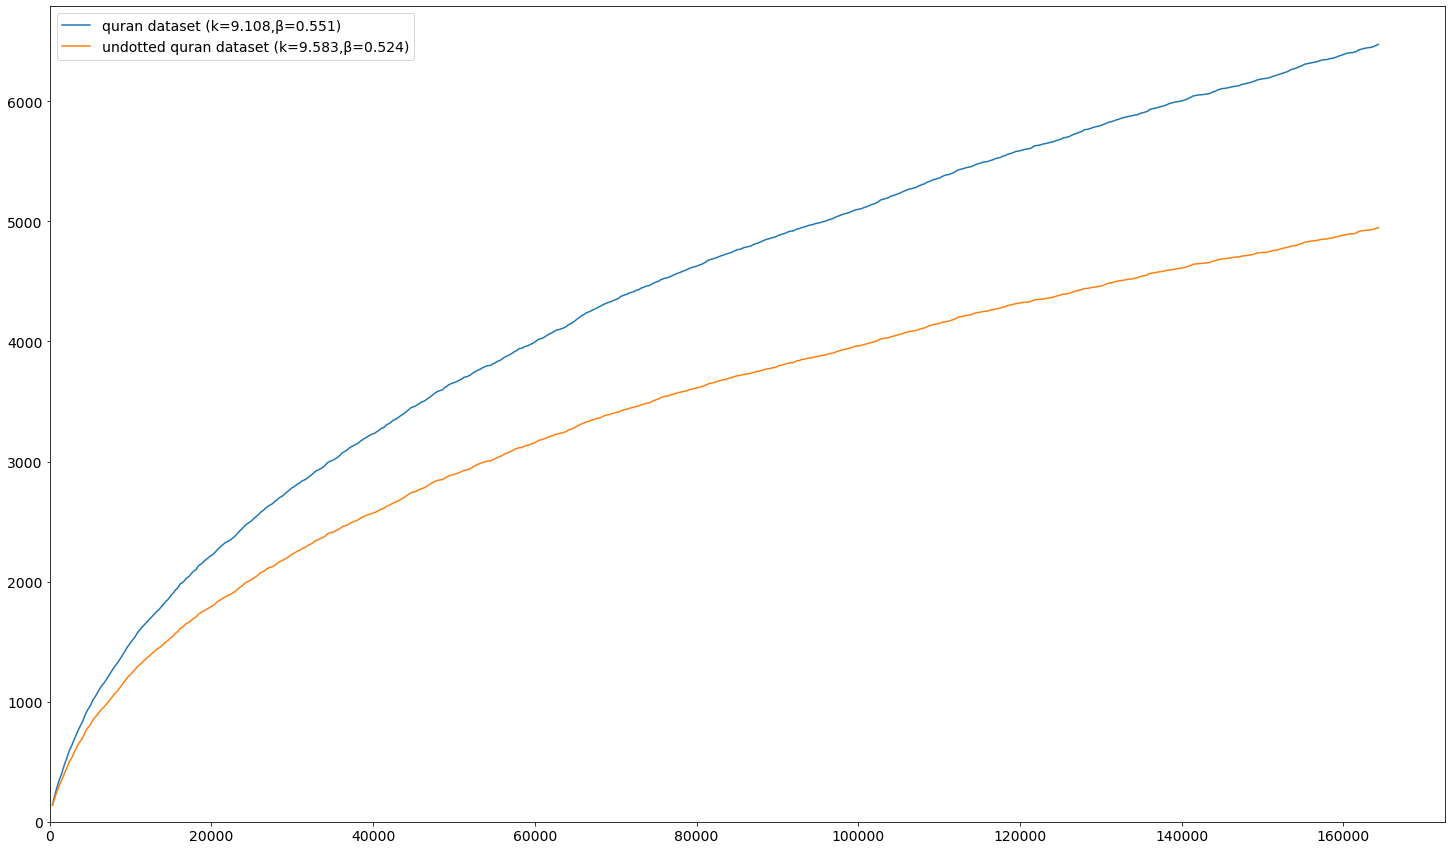

In [14]:
plot_heaps(
    datasets=[all_datasets[0]],
    datasets_names=[all_datasets_names[0]],
)

  0%|          | 0/501 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.39468237589243377  k  114.69149572018249  for dataset:  aggregated
some samples of the dotted X,Y lists:
[1730572.0, 3472397.0, 5203010.0, 6934778.0, 8656292.0, 10401194.0, 12150232.0, 13887002.0, 15667185.0, 17409664.0]
[29767.0, 40762.0, 48710.0, 55209.0, 60565.0, 65544.0, 70089.0, 74151.0, 78041.0, 81464.0]


  0%|          | 0/637565 [00:00<?, ?it/s]

  0%|          | 0/7714858 [00:00<?, ?it/s]

  0%|          | 0/4636663 [00:01<?, ?it/s]

  0%|          | 0/2784041 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.35734843154962775  undotted k  134.2740342267137  for dataset:  aggregated
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



  0%|          | 0/501 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.35603233031303044  k  142.36804984982766  for dataset:  news
some samples of the dotted X,Y lists:
[645309.0, 1299897.0, 1954608.0, 2605272.0, 3256467.0, 3896595.0, 4550665.0, 5190689.0, 5832534.0, 6483137.0]
[14995.0, 20038.0, 23610.0, 26500.0, 28900.0, 31002.0, 32950.0, 34624.0, 36112.0, 37518.0]


  0%|          | 0/501 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.3279132202789391  undotted k  151.03119551988044  for dataset:  news
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



  0%|          | 0/501 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.41025397946231634  k  72.95677523405185  for dataset:  wikipedia
some samples of the dotted X,Y lists:
[823235.0, 1649208.0, 2463609.0, 3281641.0, 4105200.0, 4942388.0, 5767087.0, 6580935.0, 7416764.0, 8258772.0]
[18043.0, 24700.0, 29570.0, 33534.0, 37063.0, 40077.0, 42823.0, 45363.0, 47717.0, 49908.0]


  0%|          | 0/501 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.3760083929707421  undotted k  83.7315861372179  for dataset:  wikipedia
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



  0%|          | 0/501 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.40802869550212795  k  121.15745753850392  for dataset:  poems
some samples of the dotted X,Y lists:
[144770.0, 289522.0, 433894.0, 578313.0, 723607.0, 868143.0, 1013954.0, 1158924.0, 1302737.0, 1447705.0]
[11464.0, 16824.0, 20910.0, 24239.0, 27155.0, 29810.0, 32117.0, 34219.0, 36130.0, 37960.0]


  0%|          | 0/501 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.3702370331708247  undotted k  130.23531176229866  for dataset:  poems
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



  0%|          | 0/501 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.35345590622843054  k  144.18170123319987  for dataset:  sanadset hadeeth
some samples of the dotted X,Y lists:
[116342.0, 231352.0, 342082.0, 444332.0, 560837.0, 678557.0, 807318.0, 925830.0, 1035770.0, 1152805.0]
[5975.0, 8865.0, 10807.0, 12307.0, 13763.0, 15103.0, 16357.0, 17433.0, 18275.0, 19205.0]


  0%|          | 0/501 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.3241413998308773  undotted k  151.848501919571  for dataset:  sanadset hadeeth
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



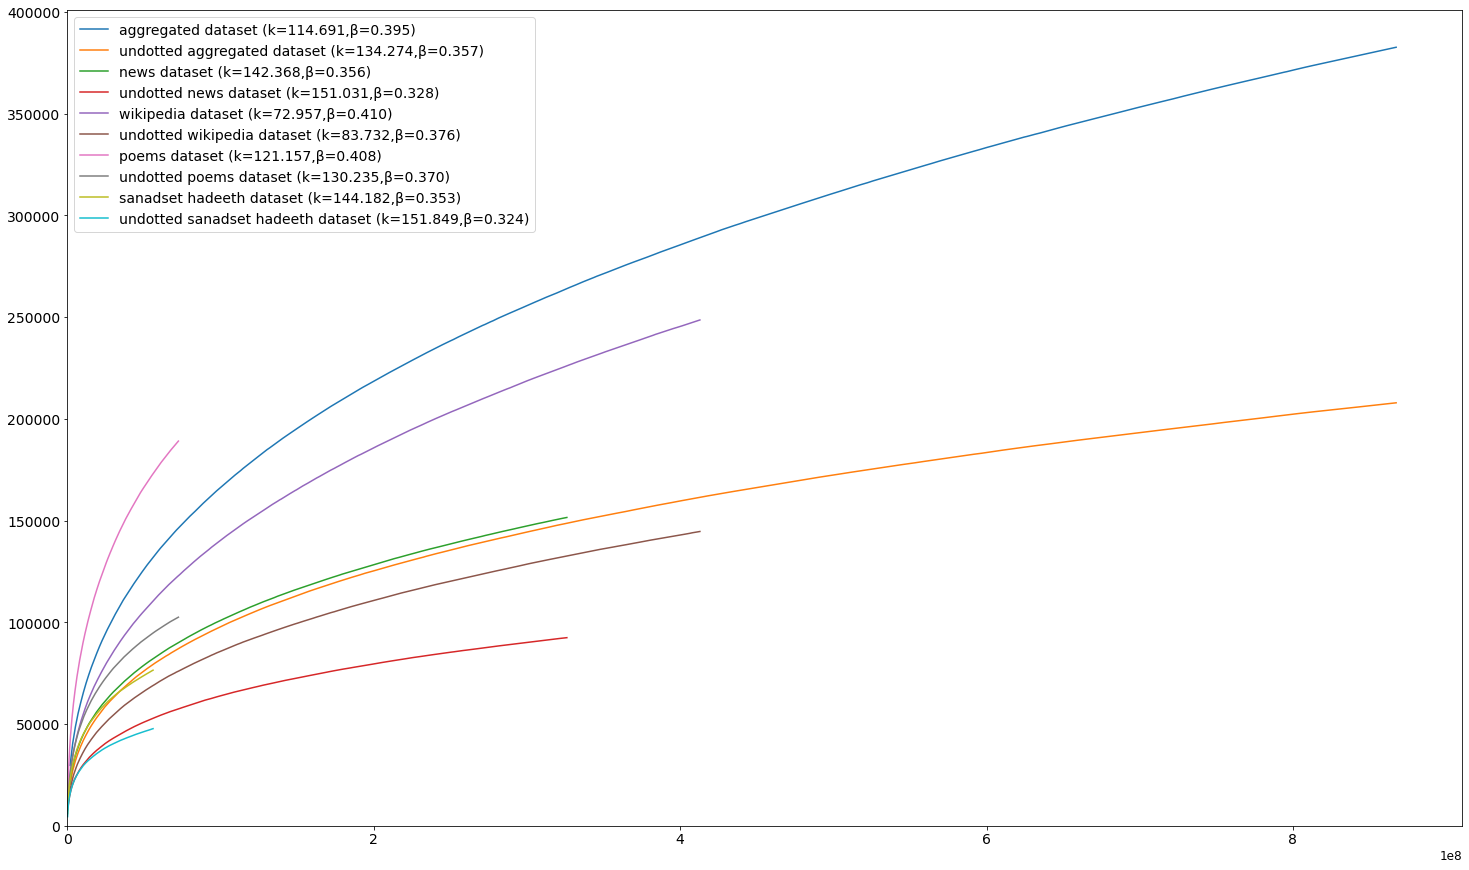

In [15]:
plot_heaps(
    datasets=all_datasets[:0:-1],
    datasets_names=all_datasets_names[:0:-1],
)